In [1]:
import pandas as pd

df = pd.read_parquet("imagenette/active_labeled.parquet")


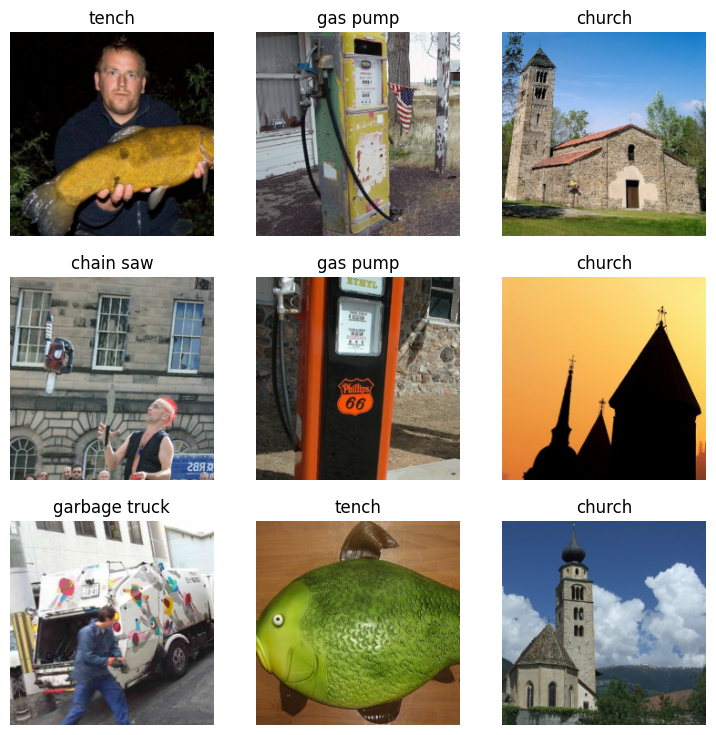

In [2]:
from fastai.vision.all import *

base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label",
    bs=16,
    item_tfms=Resize(320),
    batch_tfms=aug_transforms(size=224),
)

dls.show_batch()

In [3]:
learn = vision_learner(dls, "convnext_tiny_in22k", metrics=accuracy).to_fp16()
learn.fine_tune(5, 5e-3)


/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,3.521449,5.301932,0.388889,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.530945,2.754733,0.444444,00:01
1,0.543196,1.067314,0.666667,00:01
2,0.427499,0.516807,0.888889,00:01
3,0.340091,0.503869,0.888889,00:01
4,0.266492,0.482269,0.888889,00:01


In [4]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [17]:
import pandas as pd

df = pd.read_parquet("imagenette/unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

9369

In [18]:
from fastai.vision.all import *
import torch

# Initialize a list to store features from all batches
all_features = []

# Define a hook function to append outputs to the list
def hook_fn(module, input, output):
    all_features.append(output.detach().cpu())  # Move to CPU to save GPU memory

# Attach the hook to the penultimate layer
penultimate_layer = learn.model[1][4]
handle = penultimate_layer.register_forward_hook(hook_fn)

# Run inference on the DataLoader
test_dl = dls.test_dl(filepaths, bs=16)
preds, _, cls_preds = learn.get_preds(dl=test_dl, with_decoded=True)

# Remove the hook (optional but recommended)
handle.remove()

# Concatenate all batches into a single tensor
features = torch.cat(all_features)
print(features.shape)  # Should be [30, 512]

/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


torch.Size([9369, 512])


/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


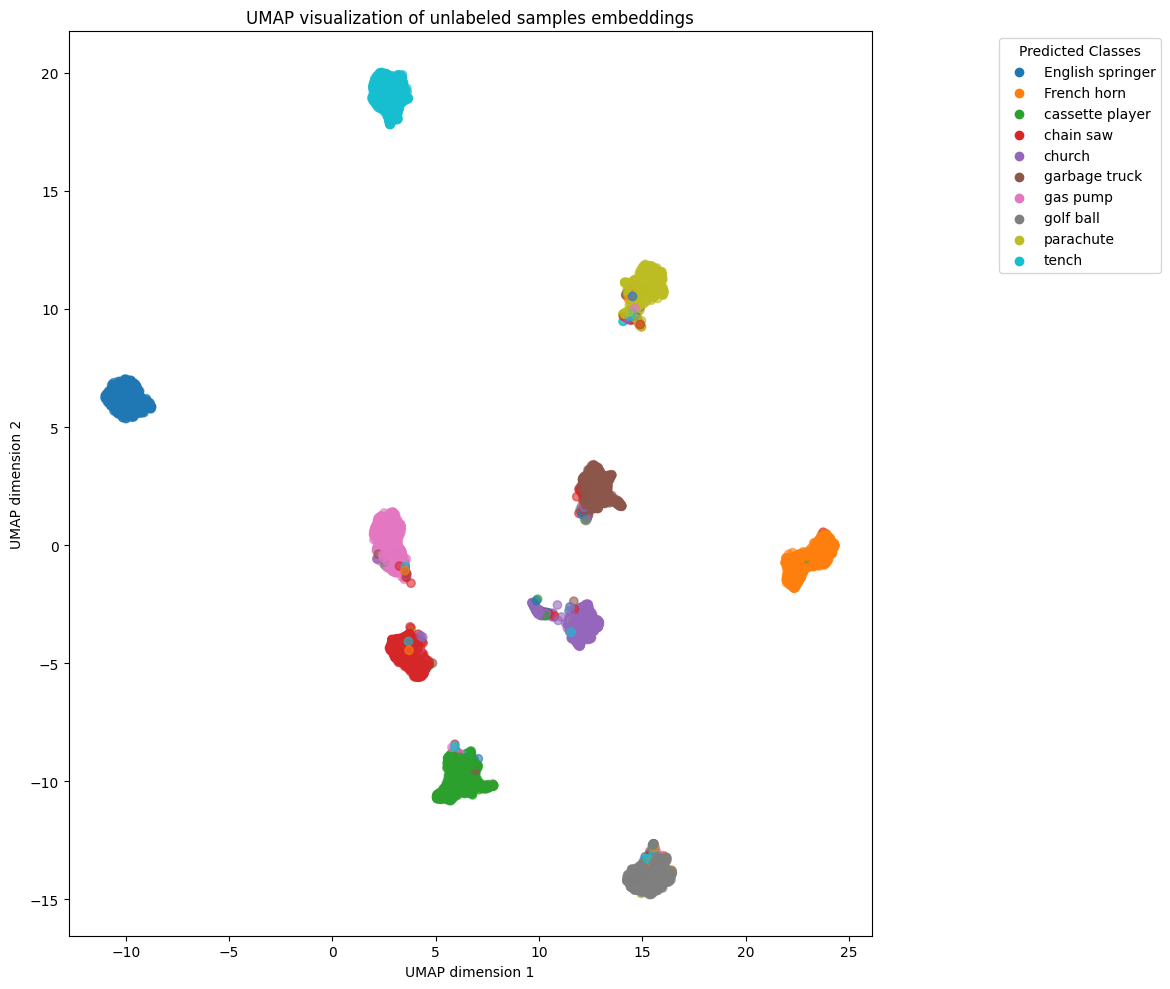

Unlabeled samples embeddings shape: torch.Size([9369, 512])


In [23]:
from umap import UMAP

# Convert to numpy and create UMAP visualization
embeddings_np = features.numpy()
labels_np = cls_preds.numpy()

# Apply UMAP instead of t-SNE
umap = UMAP(n_components=2, random_state=None, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap.fit_transform(embeddings_np)

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=labels_np, cmap='tab10', alpha=0.6)

# Add legend with class names
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10.)], label=class_name)
                  for i, class_name in enumerate(dls.vocab)]
plt.legend(handles=legend_elements, title="Predicted Classes", 
          bbox_to_anchor=(1.15, 1), loc='upper left')

plt.title('UMAP visualization of unlabeled samples embeddings')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.tight_layout()
plt.show()

# Print shape of test embeddings
print(f"Unlabeled samples embeddings shape: {features.shape}")


In [26]:
from plotly import graph_objects as go
import numpy as np

# Convert to numpy and create UMAP visualization
embeddings_np = features.numpy()
labels_np = cls_preds.numpy()

# Apply UMAP
umap = UMAP(n_components=2, random_state=None, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap.fit_transform(embeddings_np)

# Create interactive scatter plot with plotly
fig = go.Figure()

# Add traces for each class
for i, class_name in enumerate(dls.vocab):
    mask = labels_np == i
    hover_texts = [f"File: {filepath}<br>Predicted: {class_name}" 
                  for filepath in np.array(filepaths)[mask]]
    
    fig.add_trace(go.Scatter(
        x=embeddings_2d[mask, 0],
        y=embeddings_2d[mask, 1],
        mode='markers',
        name=class_name,
        hovertext=hover_texts,
        hoverinfo='text',
        marker=dict(size=8, opacity=0.6)
    ))

# Update layout
fig.update_layout(
    title='UMAP visualization of unlabeled samples embeddings',
    xaxis_title='UMAP dimension 1',
    yaxis_title='UMAP dimension 2',
    width=1200,
    height=800,
    hovermode='closest'
)

# Show the plot
fig.show()

# Print shape of test embeddings
print(f"Unlabeled samples embeddings shape: {features.shape}")

/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Unlabeled samples embeddings shape: torch.Size([9369, 512])


In [38]:
# First, create the clean interactive plot
from plotly import graph_objects as go
import numpy as np

# Convert to numpy and create UMAP visualization
embeddings_np = features.numpy()
labels_np = cls_preds.numpy()

# Apply UMAP
umap = UMAP(n_components=2, random_state=None, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap.fit_transform(embeddings_np)

# Create interactive scatter plot with plotly
fig = go.Figure()

# Add traces for each class
for i, class_name in enumerate(dls.vocab):
    mask = labels_np == i
    hover_texts = [f"File: {filepath}<br>Predicted: {class_name}" 
                  for filepath in np.array(filepaths)[mask]]
    
    fig.add_trace(go.Scatter(
        x=embeddings_2d[mask, 0],
        y=embeddings_2d[mask, 1],
        mode='markers',
        name=class_name,
        hovertext=hover_texts,
        hoverinfo='text',
        marker=dict(size=8, opacity=0.6)
    ))

# Update layout
fig.update_layout(
    title='UMAP visualization of unlabeled samples embeddings',
    xaxis_title='UMAP dimension 1',
    yaxis_title='UMAP dimension 2',
    width=1200,
    height=800,
    hovermode='closest'
)

# Show the plot
fig.show()

# Then, perform the consistency analysis separately
from sklearn.neighbors import NearestNeighbors

# Number of neighbors to consider
n_neighbors = 15

# Fit nearest neighbors
nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(embeddings_2d)

# Find nearest neighbors for all points
distances, indices = nn.kneighbors(embeddings_2d)

# Calculate inconsistency scores
inconsistency_scores = []
for i in range(len(embeddings_2d)):
    # Get labels of neighbors
    neighbor_labels = labels_np[indices[i]]
    # Get the predicted label for current point
    current_label = labels_np[i]
    # Calculate percentage of neighbors with different labels
    inconsistency_score = np.mean(neighbor_labels != current_label)
    inconsistency_scores.append(inconsistency_score)

inconsistency_scores = np.array(inconsistency_scores)

# Find the most inconsistent points (e.g., top 5%)
threshold = np.percentile(inconsistency_scores, 95)
inconsistent_indices = np.where(inconsistency_scores >= threshold)[0]

print("\nMost inconsistent predictions:")
for idx in inconsistent_indices:
    print(f"File: {filepaths[idx]}")
    print(f"Predicted class: {dls.vocab[labels_np[idx]]}")
    print(f"Inconsistency score: {inconsistency_scores[idx]:.2f}")
    print("---")

# Create DataFrame of most inconsistent predictions
threshold = np.percentile(inconsistency_scores, 95)
inconsistent_indices = np.where(inconsistency_scores >= threshold)[0]

inconsistent_df = pd.DataFrame({
    'filename': [filepaths[idx] for idx in inconsistent_indices],
    'pred_label': [dls.vocab[labels_np[idx]] for idx in inconsistent_indices],
    'inconsistency_score': [inconsistency_scores[idx] for idx in inconsistent_indices]
})

# Sort by inconsistency score in descending order
inconsistent_df = inconsistent_df.sort_values('inconsistency_score', ascending=False)

# Display the DataFrame
inconsistent_df

/home/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




Most inconsistent predictions:
File: data/imagenette/2/00095.jpg
Predicted class: English springer
Inconsistency score: 0.87
---
File: data/imagenette/2/00102.jpg
Predicted class: English springer
Inconsistency score: 0.93
---
File: data/imagenette/2/00103.jpg
Predicted class: tench
Inconsistency score: 0.93
---
File: data/imagenette/2/00106.jpg
Predicted class: French horn
Inconsistency score: 0.87
---
File: data/imagenette/2/00128.jpg
Predicted class: golf ball
Inconsistency score: 0.93
---
File: data/imagenette/2/00129.jpg
Predicted class: gas pump
Inconsistency score: 0.80
---
File: data/imagenette/2/00150.jpg
Predicted class: garbage truck
Inconsistency score: 0.47
---
File: data/imagenette/2/00161.jpg
Predicted class: garbage truck
Inconsistency score: 0.47
---
File: data/imagenette/2/00167.jpg
Predicted class: tench
Inconsistency score: 0.93
---
File: data/imagenette/2/00182.jpg
Predicted class: chain saw
Inconsistency score: 0.87
---
File: data/imagenette/2/00205.jpg
Predicted

,filename,pred_label,inconsistency_score
468,data/imagenette/5/09413.jpg,tench,0.933333
467,data/imagenette/5/09163.jpg,cassette player,0.933333
1,data/imagenette/2/00102.jpg,English springer,0.933333
2,data/imagenette/2/00103.jpg,tench,0.933333
466,data/imagenette/5/09059.jpg,English springer,0.933333
...,...,...,...
51,data/imagenette/2/00944.jpg,chain saw,0.400000
429,data/imagenette/8/07394.jpg,golf ball,0.400000
24,data/imagenette/2/00444.jpg,cassette player,0.400000
19,data/imagenette/2/00395.jpg,cassette player,0.400000


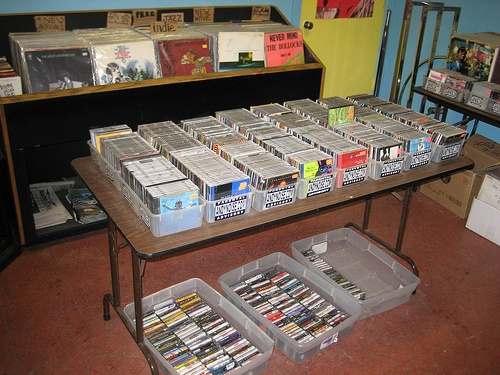

In [42]:
from PIL import Image

Image.open('data/imagenette/2/00102.jpg')